In [60]:
import sklearn

In [2]:
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.utils import to_networkx, is_undirected, contains_self_loops
import torch
import torch.nn.functional as F

In [3]:
import networkx as nx
import networkx.algorithms.isomorphism as iso_utils
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import seaborn

In [5]:
consider_node_features = True

In [46]:
import random
def set_seed(seed = 42):
    # Torch RNG
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Python RNG
    np.random.seed(seed)
    random.seed(seed)

In [8]:
def partition_iso(dataset):
    partitions = [] # Found partitions
    for G_idx, G_torch in enumerate(dataset): # Loop over each element
        if consider_node_features and 'x' in G_torch:
            G_nx = to_networkx(G_torch, node_attrs=['x'])
        else:
            G_nx = to_networkx(G_torch)
        
        nm = None
        if consider_node_features and 'x' in G_torch:
            nm = iso_utils.categorical_node_match("x", None)
        found = False # Note it is not yet part of a know partition
        for p in partitions:
            if nx.is_isomorphic(G_nx, p[0][2], node_match=nm): # Found a partition for it!
                p.append((G_idx, 0, G_nx))
                found = True
                break
        if not found: # Make a new partition for it.
            partitions.append([(G_idx, 0, G_nx)])
    return partitions

In [9]:
def partition_labels(dataset):
    partitions = [] # Found partitions
    for G_idx, G_torch in enumerate(dataset): # Loop over each element
        assert is_undirected(G_torch.edge_index)
        
        G_nx = to_networkx(G_torch)
        for y_idx in range(len(G_torch.y)):
            found = False # Note it is not yet part of a know partition
            for p in partitions:
                if G_torch.y[y_idx].item() == p[0][2]: # Found a partition for it!
                    p.append((G_idx, y_idx, G_torch.y[y_idx].item()))
                    found = True
                    break
            if not found: # Make a new partition for it.
                partitions.append([(G_idx, y_idx, G_torch.y[y_idx].item())])
    return partitions

In [10]:
def partition_hashes(dataset):
    partitions = [] # Found partitions
    for G_idx, y_idx, _hash in dataset: # Loop over each element
        found = False # Note it is not yet part of a know partition
        for p in partitions:
            if _hash == p[0][2]: # Found a partition for it!
                p.append((G_idx, y_idx, _hash))
                found = True
                break
        if not found: # Make a new partition for it.
            partitions.append([(G_idx, y_idx, _hash)])
    return partitions

In [11]:
def eq_class_stats(dataset, name, partition):
    print('num', name, 'eq classes:', len(partition))
    print('num singleton', name, 'classes:', sum([int(len(c) == 1) for c in partition]))
    return [len(partition), sum([int(len(c) == 1) for c in partition])]

In [39]:
def uncert(U, V, mode):
    N = sum([len(u) for u in U])
    
    labels_pred = np.zeros(N)
    labels_true = np.zeros(N)
    
    for partition, labels in [(U, labels_pred), (V, labels_true)]:
        for p_label, p in enumerate(partition):
            for G_p, G_n_p, _ in p:
                if mode == "graph":
                    labels[G_p] = p_label
                else:
                    labels[G_n_p] = p_label
    
    return sklearn.metrics.adjusted_mutual_info_score(labels_pred, labels_true)

In [13]:
def acc(U, V):
    num_correct = 0
    total = 0
    for _, u in enumerate(U):
        labels = []
        for G_u, G_n_u, _ in u:
            for _, v in enumerate(V):
                for G_v, G_n_v, label in v:
                    if G_u == G_v and G_n_u == G_n_v:
                        labels.append(label)
        maj_vote = max(set(labels), key = labels.count)
        for l in labels:
            if l == maj_vote:
                num_correct += 1
        total += len(labels)
    return (num_correct / total) * 100

In [14]:
dataset_types = {
    "IMDB-BINARY" : ["graph", "social"],
    "IMDB-MULTI" : ["graph", "social"],
    "REDDIT-BINARY" : ["graph", "social"],
    "PROTEINS" : ["graph", "bio"],
    "PTC_MR" : ["graph", "bio"],
    "MUTAG" : ["graph", "bio"],
    "Cora" : ["node", "citation"],
    "CiteSeer" : ["node", "citation"],
    "PubMed" : ["node", "citation"],
}
cols = ["Level", "Domain"]
pd_dataset_types = pd.DataFrame.from_dict(dataset_types, orient='index', columns=cols)
print(pd_dataset_types.to_latex())

\begin{tabular}{lll}
\toprule
{} &  Level &    Domain \\
\midrule
IMDB-BINARY   &  graph &    social \\
IMDB-MULTI    &  graph &    social \\
REDDIT-BINARY &  graph &    social \\
PROTEINS      &  graph &       bio \\
PTC\_MR        &  graph &       bio \\
MUTAG         &  graph &       bio \\
Cora          &   node &  citation \\
CiteSeer      &   node &  citation \\
PubMed        &   node &  citation \\
\bottomrule
\end{tabular}



In [137]:
all_datasets = []
for dataset_name in list(dataset_types):
    if dataset_types[dataset_name][0] == "graph":
        all_datasets.append((dataset_name, TUDataset("data", dataset_name)))
    else:
        all_datasets.append((dataset_name, Planetoid("data", dataset_name)))

In [16]:
dataset_partitions = {d : {} for d in dataset_types}

In [17]:
basic_stats = {}

for dataset_name, dataset in all_datasets:
    stats = []
    
    print("======", dataset_name, "======")
    stats.append(len(dataset))
    print('total graphs:', stats[-1])
    stats.append(sum([torch.max(dataset[G_idx].edge_index).item() + 1 for G_idx in range(len(dataset))]) / stats[-1])
    print('avg nodes:', stats[-1])
    if "x" in dataset[0]:
        stats.append("Yes")
    else:
        stats.append("No")
    
    label_eq_classes = partition_labels(dataset)
    dataset_partitions[dataset_name]["label"] = label_eq_classes
    stats.extend(eq_class_stats(dataset, "label", label_eq_classes))
    print()
    
    basic_stats[dataset_name] = stats[:4]

====== IMDB-BINARY ======
total graphs: 1000
avg nodes: 19.773
num label eq classes: 2
num singleton label classes: 0

====== IMDB-MULTI ======
total graphs: 1500
avg nodes: 13.001333333333333
num label eq classes: 3
num singleton label classes: 0

====== REDDIT-BINARY ======
total graphs: 2000
avg nodes: 429.627
num label eq classes: 2
num singleton label classes: 0

====== PROTEINS ======
total graphs: 1113
avg nodes: 39.05750224618149
num label eq classes: 2
num singleton label classes: 0

====== PTC_MR ======
total graphs: 344
avg nodes: 14.287790697674419
num label eq classes: 2
num singleton label classes: 0

====== MUTAG ======
total graphs: 188
avg nodes: 17.930851063829788
num label eq classes: 2
num singleton label classes: 0

====== Cora ======
total graphs: 1
avg nodes: 2708.0
num label eq classes: 7
num singleton label classes: 0

====== CiteSeer ======
total graphs: 1
avg nodes: 3327.0
num label eq classes: 6
num singleton label classes: 0

====== PubMed ======
total grap

In [18]:
cols = [r'\# graphs', r'Avg \# nodes/graph', r'Node features?', r'$|{\cal E}_y|$'] # , '# singleton labels', '# unique graph sizes', '# singleton graph sizes', 'uncert(graph size, labels)', 'acc(graph size, labels)']
pd_basic_stats = pd.DataFrame.from_dict(basic_stats, orient='index', columns=cols)
print(pd_basic_stats.to_latex(escape=False))

\begin{tabular}{lrrlr}
\toprule
{} &  \# graphs &  Avg \# nodes/graph & Node features? &  $|{\cal E}_y|$ \\
\midrule
IMDB-BINARY   &       1000 &           19.773000 &             No &               2 \\
IMDB-MULTI    &       1500 &           13.001333 &             No &               3 \\
REDDIT-BINARY &       2000 &          429.627000 &             No &               2 \\
PROTEINS      &       1113 &           39.057502 &            Yes &               2 \\
PTC_MR        &        344 &           14.287791 &            Yes &               2 \\
MUTAG         &        188 &           17.930851 &            Yes &               2 \\
Cora          &          1 &         2708.000000 &            Yes &               7 \\
CiteSeer      &          1 &         3327.000000 &            Yes &               6 \\
PubMed        &          1 &        19717.000000 &            Yes &               3 \\
\bottomrule
\end{tabular}



In [19]:
iso_stats = {}

for dataset_name, dataset in all_datasets:
    if dataset_types[dataset_name][0] == "node":
        iso_stats[dataset_name] = [None, None, None, None]
        continue
    
    print("======", dataset_name, "======")
    stats = []

    iso_eq_classes = partition_iso(dataset)
    dataset_partitions[dataset_name]["iso"] = iso_eq_classes
    stats.extend(eq_class_stats(dataset, "iso", iso_eq_classes))
    print()
    
    iso_stats[dataset_name] = stats

====== IMDB-BINARY ======
num iso eq classes: 537
num singleton iso classes: 421

====== IMDB-MULTI ======
num iso eq classes: 387
num singleton iso classes: 288

====== REDDIT-BINARY ======
num iso eq classes: 1998
num singleton iso classes: 1996

====== PROTEINS ======
num iso eq classes: 1069
num singleton iso classes: 1050

====== PTC_MR ======
num iso eq classes: 328
num singleton iso classes: 313

====== MUTAG ======
num iso eq classes: 175
num singleton iso classes: 164



In [20]:
import matplotlib.pyplot as plt
from itertools import count
import os
plt.rcParams["figure.figsize"] = (20,3)

In [21]:
def draw_indist_graphs(wl, iso, dataset, dataset_name):
    indist_pairs = []
    for idx_u, u in enumerate(wl):
        for G_u_1, _, _ in u:
            for G_u_2, _, _ in u:
                for idx_v, v in enumerate(iso):
                    G_v_all = [G_v for G_v, _, _ in v]
                    if (G_u_1 in G_v_all and G_u_2 not in G_v_all) \
                        or (G_u_1 not in G_v_all and G_u_2 in G_v_all):
                        indist_pairs.append((G_u_1, G_u_2))
                        
                        to_draw = []
                        for G_u in [G_u_1, G_u_2]:
                            G_torch = dataset[G_u]
                            if consider_node_features and 'x' in G_torch:
                                G_nx = to_networkx(G_torch, node_attrs=['x'])
                            else:
                                G_nx = to_networkx(G_torch)
                            to_draw.append(G_nx)
                        
                        nm = iso_utils.categorical_node_match("x", None)
                        assert not nx.is_isomorphic(to_draw[0], to_draw[1], node_match=nm)
                            
                        g = to_draw[0]
                        pos = nx.spring_layout(g)
                        if 'x' in g.nodes[0]:
                            # get unique groups
                            g = to_draw[0]
                            groups = set([tuple(e) for e in nx.get_node_attributes(g, 'x').values()])
                            mapping = dict(zip(sorted(groups), count()))
                        else:
                            mapping = None
                
                        fig, axes = plt.subplots(nrows=1, ncols=len(to_draw))
                        ax = axes.flatten()
                        for ax_i in range(len(to_draw)):
                            g = to_draw[ax_i]

                            nodes = g.nodes()
                            if mapping is None:
                                colors = None
                            else:
                                colors = [mapping[tuple(g.nodes[n]['x'])] for n in nodes]

                            # drawing nodes and edges separately so we can capture collection for colobar
                            ec = nx.draw_networkx_edges(g, pos, alpha=0.2, ax=ax[ax_i])
                            nc = nx.draw_networkx_nodes(g, pos, ax=ax[ax_i], nodelist=nodes, node_color=colors, node_size=100, cmap=plt.cm.jet)
                            ax[ax_i].set_axis_off()
                        plt.tight_layout()
                        plt.colorbar(nc)

                        results_dir = './plots/' + dataset_name + '/'
                        file_name = dataset_name + '_' + str(G_u_1) + '_' + str(G_u_2)
                        if not os.path.isdir(results_dir):
                            os.makedirs(results_dir)
                        plt.savefig(results_dir + file_name)

In [22]:
from collections import Counter, defaultdict
from hashlib import blake2b

def _hash_label(label, digest_size):
    return blake2b(label.encode("ascii"), digest_size=digest_size).hexdigest()


def _init_node_labels(G, edge_attr, node_attr):
    if node_attr:
        return {u: str(dd[node_attr]) for u, dd in G.nodes(data=True)}
    elif edge_attr:
        return {u: "" for u in G}
    else:
        # use same hash for all nodes if no features
        return {u: "0" for u, deg in G.degree()}


def _neighborhood_aggregate(G, node, node_labels, edge_attr=None):
    """
    Compute new labels for given node by aggregating
    the labels of each node's neighbors.
    """
    label_list = []
    for nbr in G.neighbors(node):
        prefix = "" if edge_attr is None else str(G[node][nbr][edge_attr])
        label_list.append(prefix + node_labels[nbr])
    return node_labels[node] + "".join(sorted(label_list))


def weisfeiler_lehman_graph_hash(
    G, edge_attr=None, node_attr=None, iterations=3, digest_size=16
):
    def weisfeiler_lehman_step(G, labels, edge_attr=None):
        """
        Apply neighborhood aggregation to each node
        in the graph.
        Computes a dictionary with labels for each node.
        """
        new_labels = {}
        for node in G.nodes():
            label = _neighborhood_aggregate(G, node, labels, edge_attr=edge_attr)
            new_labels[node] = _hash_label(label, digest_size)
        return new_labels

    # set initial node labels
    node_labels = _init_node_labels(G, edge_attr, node_attr)

    subgraph_hash_counts = []
    for _ in range(iterations):
        node_labels = weisfeiler_lehman_step(G, node_labels, edge_attr=edge_attr)
        counter = Counter(node_labels.values())
        # sort the counter, extend total counts
        subgraph_hash_counts.extend(sorted(counter.items(), key=lambda x: x[0]))

    # hash the final counter
    return _hash_label(str(tuple(subgraph_hash_counts)), digest_size)

def weisfeiler_lehman_subgraph_hashes(
    G, edge_attr=None, node_attr=None, iterations=3, digest_size=16
):
    def weisfeiler_lehman_step(G, labels, node_subgraph_hashes, edge_attr=None):
        """
        Apply neighborhood aggregation to each node
        in the graph.
        Computes a dictionary with labels for each node.
        Appends the new hashed label to the dictionary of subgraph hashes
        originating from and indexed by each node in G
        """
        new_labels = {}
        for node in G.nodes():
            label = _neighborhood_aggregate(G, node, labels, edge_attr=edge_attr)
            hashed_label = _hash_label(label, digest_size)
            new_labels[node] = hashed_label
            node_subgraph_hashes[node].append(hashed_label)
        return new_labels

    node_labels = _init_node_labels(G, edge_attr, node_attr)

    node_subgraph_hashes = defaultdict(list)
    for _ in range(iterations):
        node_labels = weisfeiler_lehman_step(
            G, node_labels, node_subgraph_hashes, edge_attr
        )

    return dict(node_subgraph_hashes)

====== IMDB-BINARY ======

num wl-1 eq classes: 537
num singleton wl-1 classes: 421

num wl-2 eq classes: 537
num singleton wl-2 classes: 421

num wl-3 eq classes: 537
num singleton wl-3 classes: 421
====== IMDB-MULTI ======

num wl-1 eq classes: 387
num singleton wl-1 classes: 288

num wl-2 eq classes: 387
num singleton wl-2 classes: 288

num wl-3 eq classes: 387
num singleton wl-3 classes: 288
====== REDDIT-BINARY ======

num wl-1 eq classes: 1998
num singleton wl-1 classes: 1996

num wl-2 eq classes: 1998
num singleton wl-2 classes: 1996

num wl-3 eq classes: 1998
num singleton wl-3 classes: 1996
====== PROTEINS ======

num wl-1 eq classes: 1069
num singleton wl-1 classes: 1050

num wl-2 eq classes: 1069
num singleton wl-2 classes: 1050

num wl-3 eq classes: 1069
num singleton wl-3 classes: 1050
====== PTC_MR ======

num wl-1 eq classes: 315
num singleton wl-1 classes: 291

num wl-2 eq classes: 328
num singleton wl-2 classes: 313

num wl-3 eq classes: 328
num singleton wl-3 classes:

<ipython-input-21-81c60715dfd2>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=len(to_draw))


====== Cora ======

num wl-1 eq classes: 2693
num singleton wl-1 classes: 2683

num wl-2 eq classes: 2693
num singleton wl-2 classes: 2683

num wl-3 eq classes: 2693
num singleton wl-3 classes: 2683
====== CiteSeer ======

num wl-1 eq classes: 3319
num singleton wl-1 classes: 3311

num wl-2 eq classes: 3319
num singleton wl-2 classes: 3311

num wl-3 eq classes: 3319
num singleton wl-3 classes: 3311
====== PubMed ======

num wl-1 eq classes: 19717
num singleton wl-1 classes: 19717

num wl-2 eq classes: 19717
num singleton wl-2 classes: 19717

num wl-3 eq classes: 19717
num singleton wl-3 classes: 19717


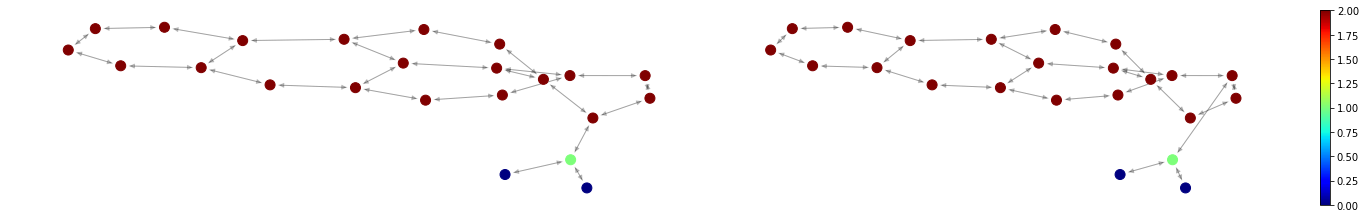

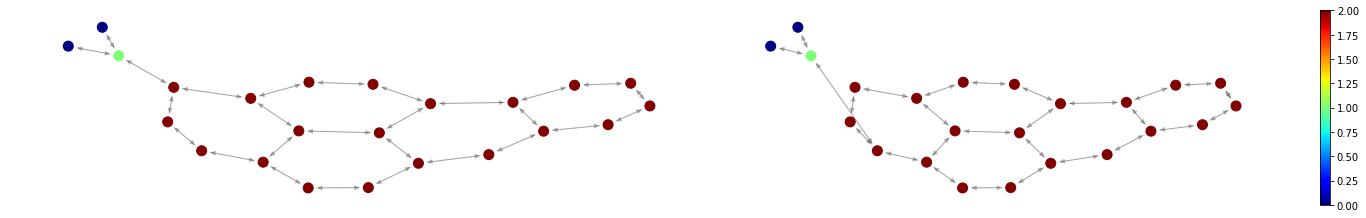

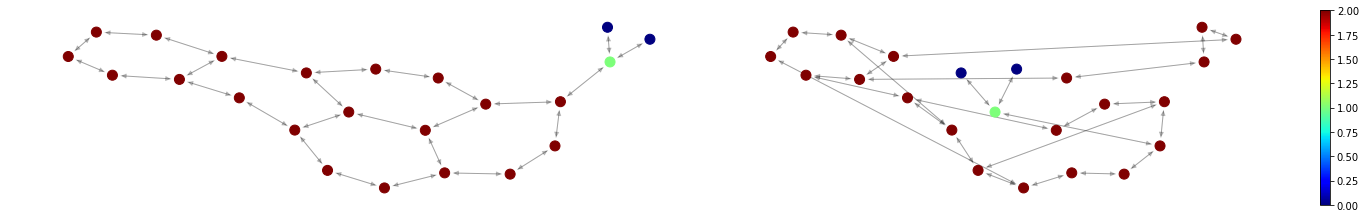

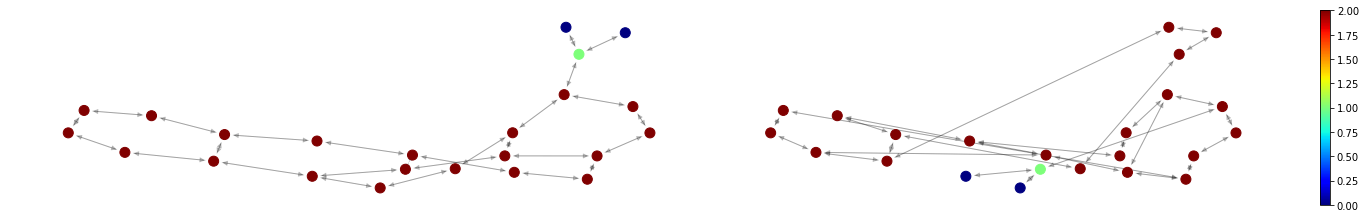

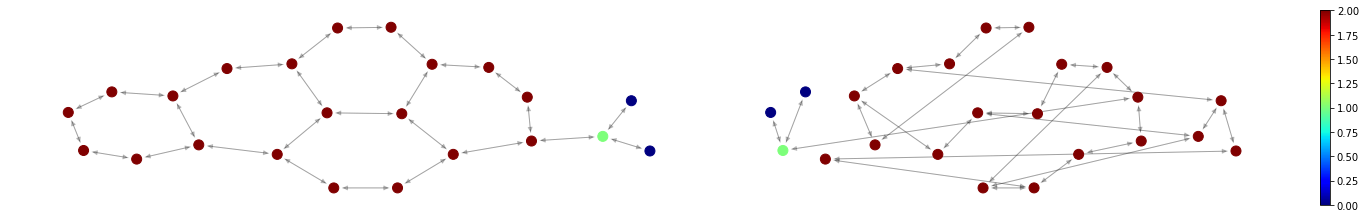

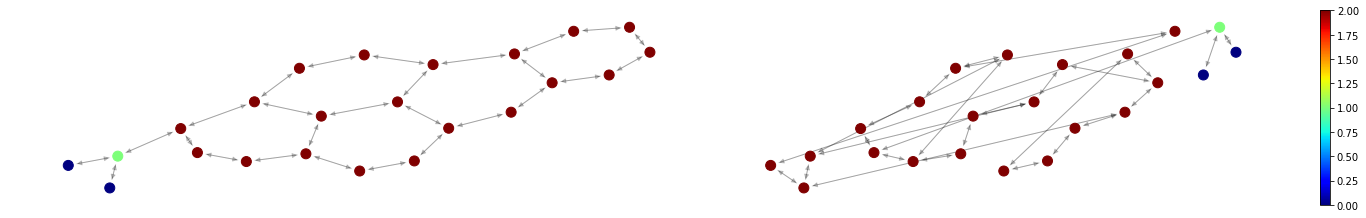

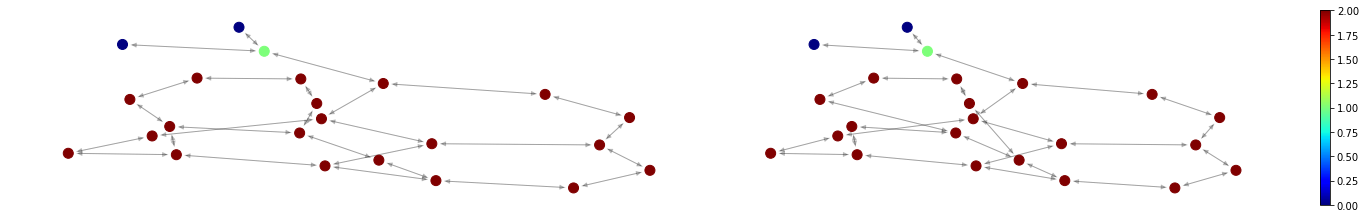

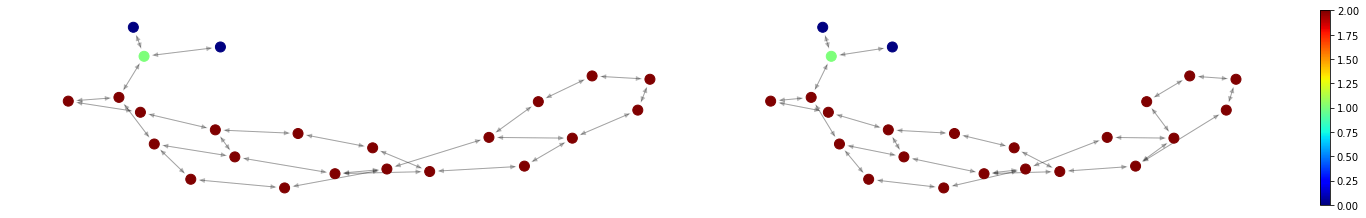

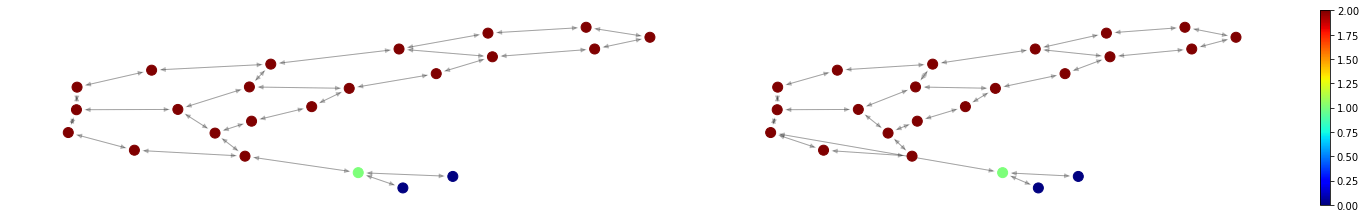

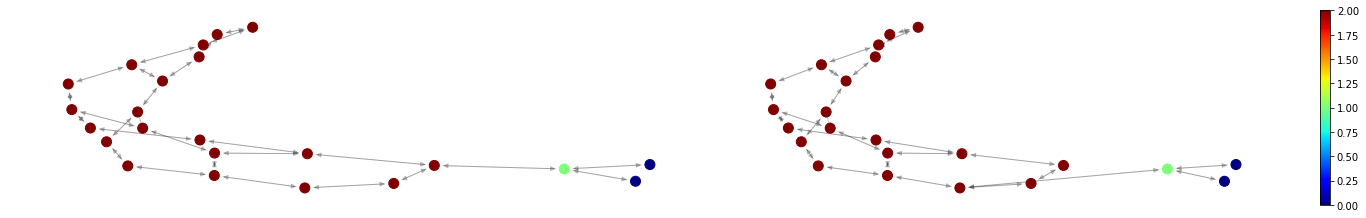

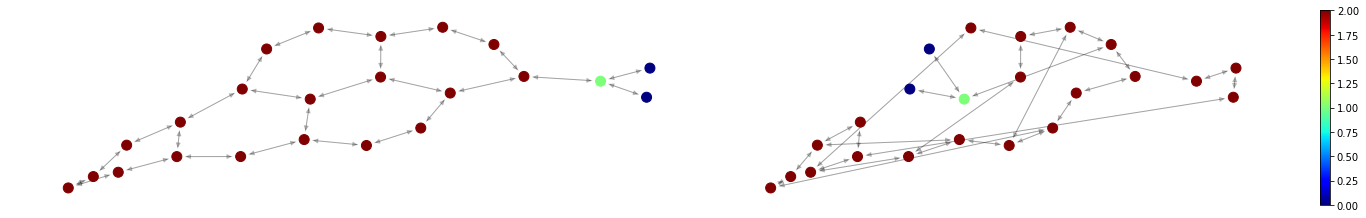

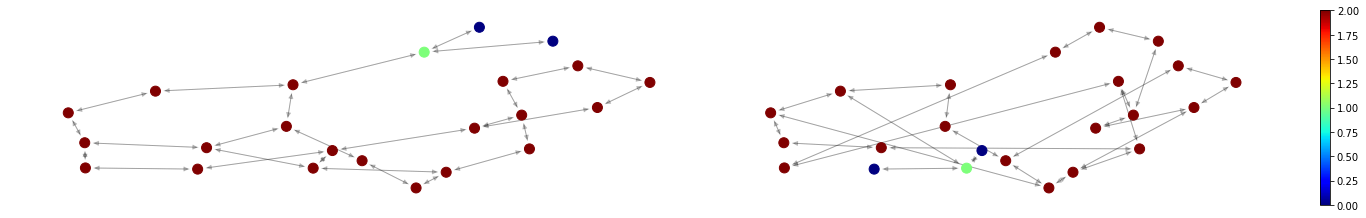

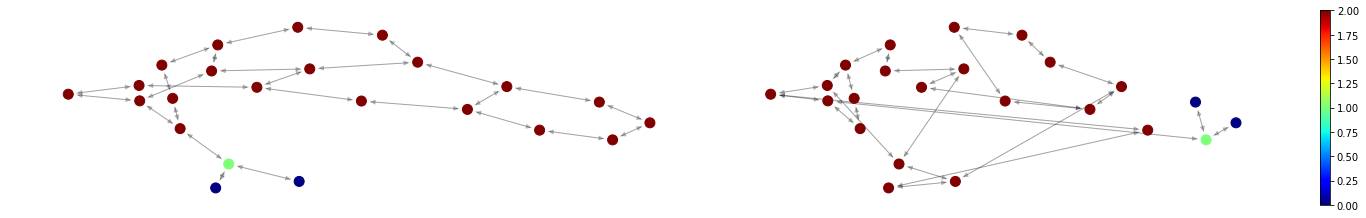

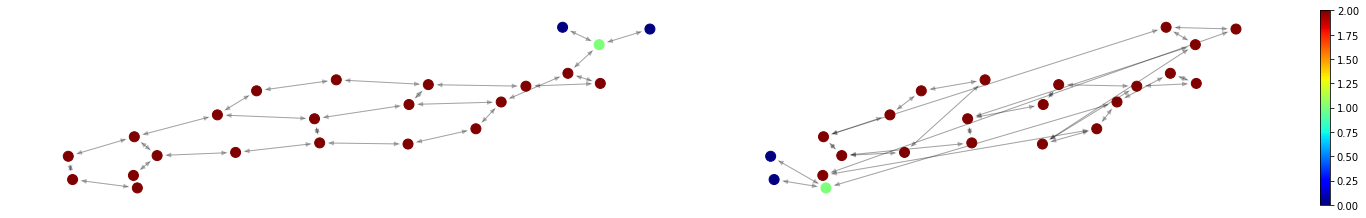

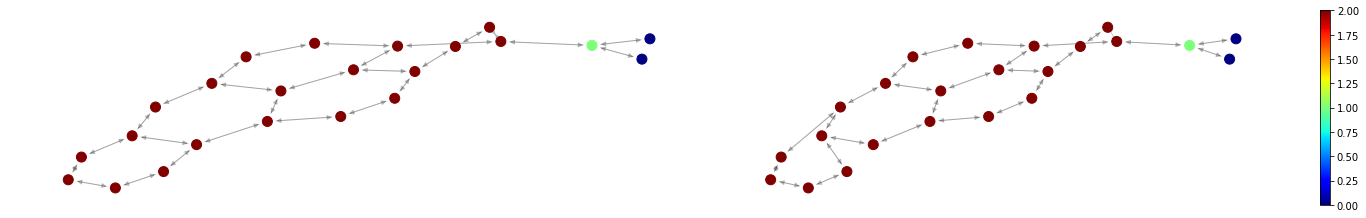

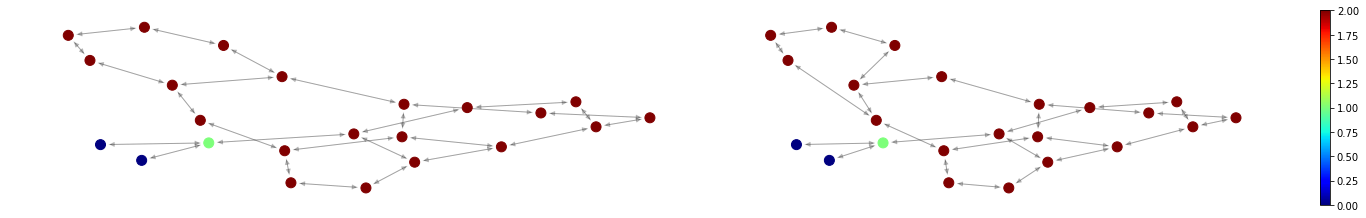

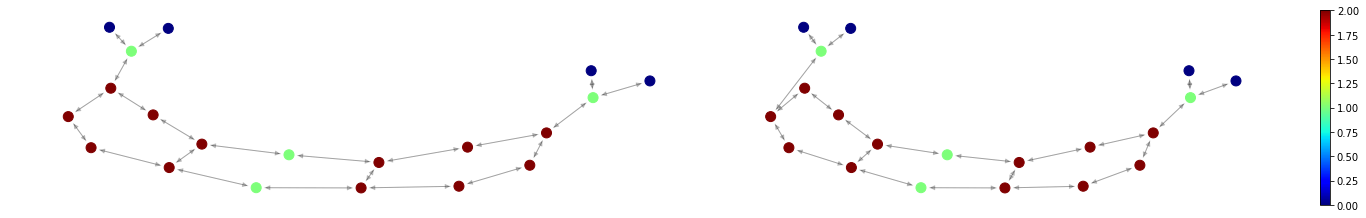

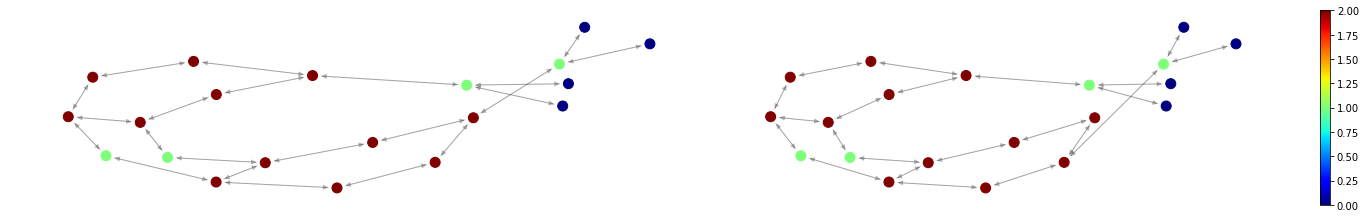

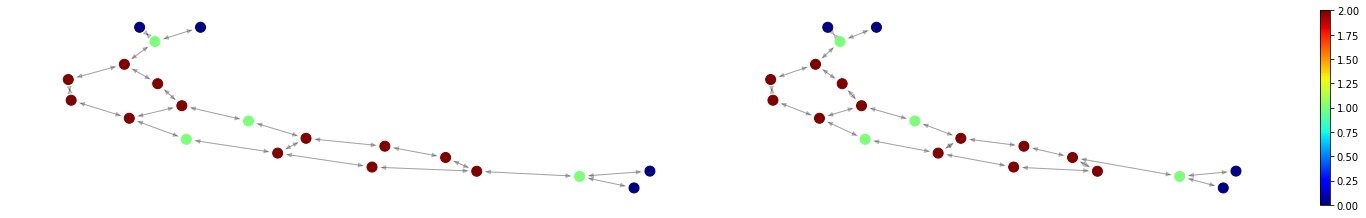

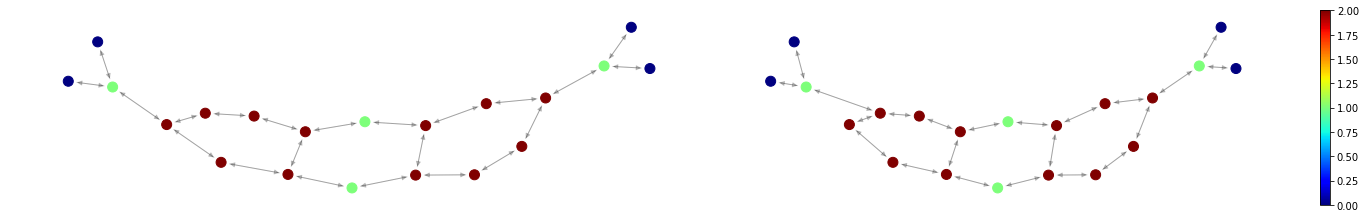

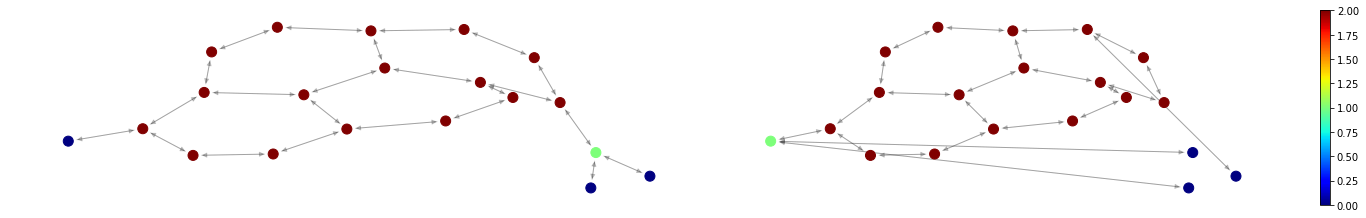

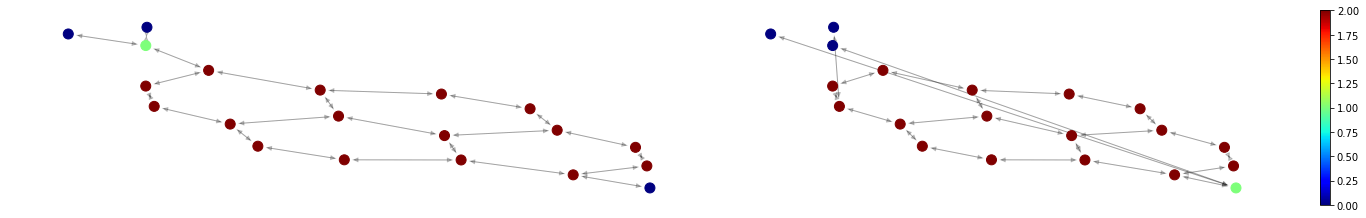

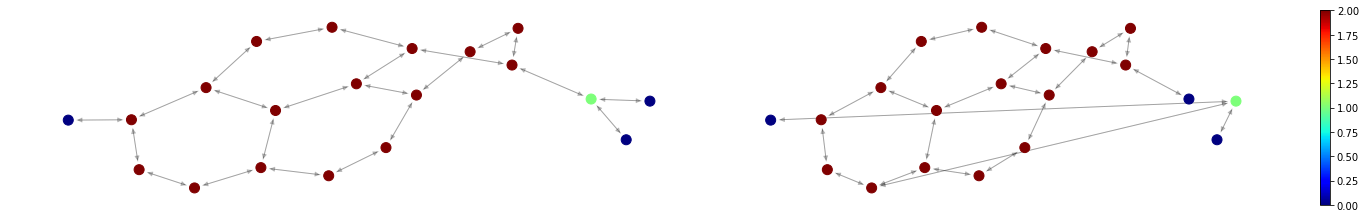

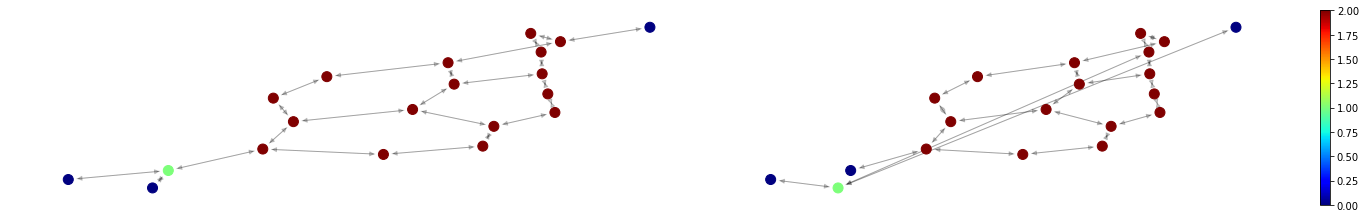

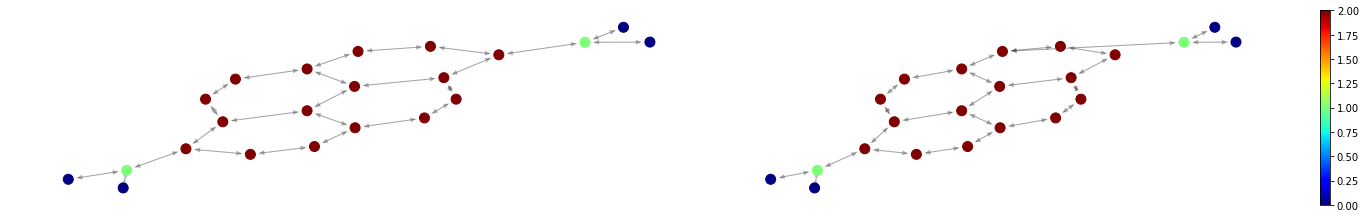

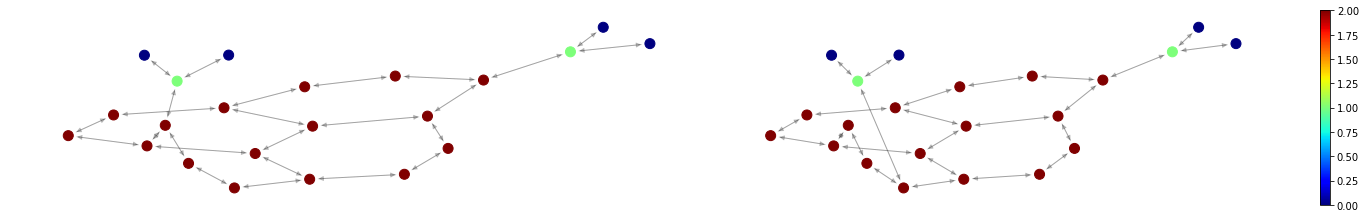

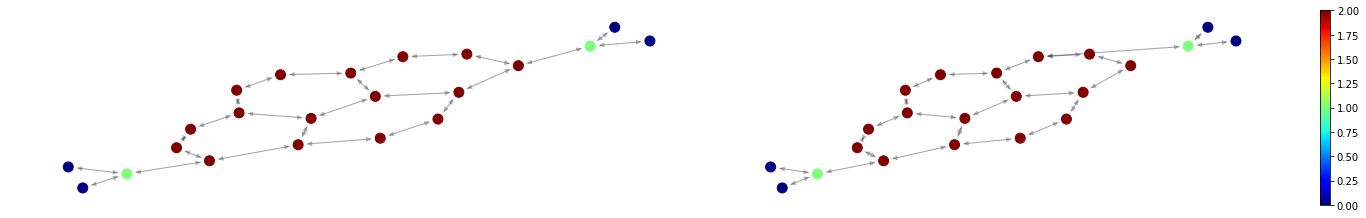

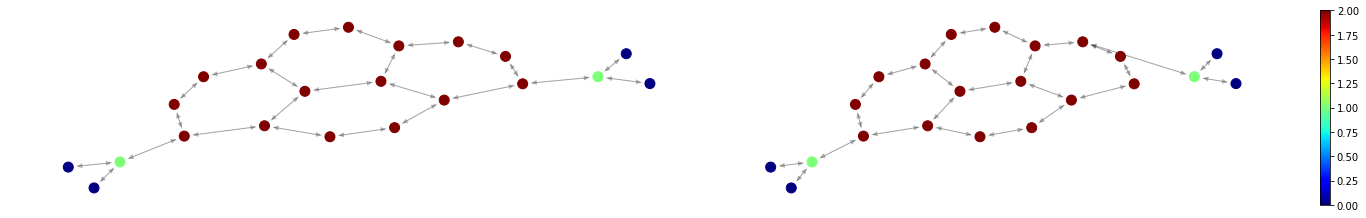

In [23]:
wl_stats = {}

for dataset_name, dataset in all_datasets:
    
    print("======", dataset_name, "======")
    cols = []
    stats = []

    if "iso" in dataset_partitions[dataset_name]:
        iso_eq_classes = dataset_partitions[dataset_name]["iso"]
    
    for k in range(1, 4):
        hashed_dataset = []
        for G_idx, G_torch in enumerate(dataset):
            if consider_node_features and 'x' in G_torch:
                G_nx = to_networkx(G_torch, node_attrs=['x'])
            else:
                G_nx = to_networkx(G_torch)
                
            if dataset_types[dataset_name][0] == "graph":
                if consider_node_features and 'x' in G_torch:
                    G_hash = weisfeiler_lehman_graph_hash(G_nx, node_attr='x', iterations=k)
                else:
                    G_hash = weisfeiler_lehman_graph_hash(G_nx, iterations=k)
                hashed_dataset.append((G_idx, 0, G_hash))
            else:
                G_hashes = weisfeiler_lehman_subgraph_hashes(G_nx, node_attr='x', iterations=max(k, 1))
                sel_idx = -1
                if k == 0:
                    sel_idx = 0
                for node_id in G_hashes:
                    hashed_dataset.append((G_idx, node_id, G_hashes[node_id][sel_idx]))

        wl_eq_classes = partition_hashes(hashed_dataset)
        print()
        dataset_partitions[dataset_name]["wl-{}".format(k)] = wl_eq_classes
        stats.extend(eq_class_stats(dataset, "wl-{}".format(k), wl_eq_classes))
        
        if k == 3 and dataset_types[dataset_name][0] == "graph":
            draw_indist_graphs(wl_eq_classes, iso_eq_classes, dataset, dataset_name)
        
        cols += [r'$|{\cal E}_{\text{WL}}^' + str(k) + r'|$', r'$\#_1 ({\cal E}_{\text{WL}}^' + str(k) + r')$']
        
    wl_stats[dataset_name] = stats

In [24]:
pd_wl_stats = pd.DataFrame.from_dict(wl_stats, orient='index', columns=cols)
print(pd_wl_stats.to_latex(escape=False))

\begin{tabular}{lrrrrrr}
\toprule
{} &  $|{\cal E}_{\text{WL}}^1|$ &  $\#_1 ({\cal E}_{\text{WL}}^1)$ &  $|{\cal E}_{\text{WL}}^2|$ &  $\#_1 ({\cal E}_{\text{WL}}^2)$ &  $|{\cal E}_{\text{WL}}^3|$ &  $\#_1 ({\cal E}_{\text{WL}}^3)$ \\
\midrule
IMDB-BINARY   &                         537 &                              421 &                         537 &                              421 &                         537 &                              421 \\
IMDB-MULTI    &                         387 &                              288 &                         387 &                              288 &                         387 &                              288 \\
REDDIT-BINARY &                        1998 &                             1996 &                        1998 &                             1996 &                        1998 &                             1996 \\
PROTEINS      &                        1069 &                             1050 &                        1069 &          

In [25]:
for dataset_name, dataset in all_datasets:
    if dataset_types[dataset_name][0] == "node":
        iso_stats[dataset_name] = wl_stats[dataset_name][-2:]
        dataset_partitions[dataset_name]["iso"] = dataset_partitions[dataset_name]["wl-3"]

In [26]:
cols = [r'$|{\cal E}_\pi|$', r'$\#_1 ({\cal E}_\pi)$']
pd_iso_stats = pd.DataFrame.from_dict(iso_stats, orient='index', columns=cols)
print(pd_iso_stats.to_latex(escape=False))

\begin{tabular}{lrr}
\toprule
{} &  $|{\cal E}_\pi|$ &  $\#_1 ({\cal E}_\pi)$ \\
\midrule
IMDB-BINARY   &               537 &                    421 \\
IMDB-MULTI    &               387 &                    288 \\
REDDIT-BINARY &              1998 &                   1996 \\
PROTEINS      &              1069 &                   1050 \\
PTC_MR        &               328 &                    313 \\
MUTAG         &               175 &                    164 \\
Cora          &              2693 &                   2683 \\
CiteSeer      &              3319 &                   3311 \\
PubMed        &             19717 &                  19717 \\
\bottomrule
\end{tabular}



In [27]:
pd_all_stats = pd.concat([pd_dataset_types, pd_basic_stats, pd_iso_stats, pd_wl_stats], axis=1)
print(pd_all_stats.columns)

Index(['Level', 'Domain', '\# graphs', 'Avg \# nodes/graph', 'Node features?',
       '$|{\cal E}_y|$', '$|{\cal E}_\pi|$', '$\#_1 ({\cal E}_\pi)$',
       '$|{\cal E}_{\text{WL}}^1|$', '$\#_1 ({\cal E}_{\text{WL}}^1)$',
       '$|{\cal E}_{\text{WL}}^2|$', '$\#_1 ({\cal E}_{\text{WL}}^2)$',
       '$|{\cal E}_{\text{WL}}^3|$', '$\#_1 ({\cal E}_{\text{WL}}^3)$'],
      dtype='object')


In [28]:
print(pd_all_stats.iloc[:, [0, 1, 4, 5]].round(2).fillna('').to_latex(escape=False))

\begin{tabular}{llllr}
\toprule
{} &  Level &    Domain & Node features? &  $|{\cal E}_y|$ \\
\midrule
IMDB-BINARY   &  graph &    social &             No &               2 \\
IMDB-MULTI    &  graph &    social &             No &               3 \\
REDDIT-BINARY &  graph &    social &             No &               2 \\
PROTEINS      &  graph &       bio &            Yes &               2 \\
PTC_MR        &  graph &       bio &            Yes &               2 \\
MUTAG         &  graph &       bio &            Yes &               2 \\
Cora          &   node &  citation &            Yes &               7 \\
CiteSeer      &   node &  citation &            Yes &               6 \\
PubMed        &   node &  citation &            Yes &               3 \\
\bottomrule
\end{tabular}



In [29]:
cols_eq = [2, 3] + list(range(6, 14))
print(pd_all_stats.iloc[:, cols_eq].round(2).fillna('').to_latex(escape=False))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  \# graphs &  Avg \# nodes/graph &  $|{\cal E}_\pi|$ &  $\#_1 ({\cal E}_\pi)$ &  $|{\cal E}_{\text{WL}}^1|$ &  $\#_1 ({\cal E}_{\text{WL}}^1)$ &  $|{\cal E}_{\text{WL}}^2|$ &  $\#_1 ({\cal E}_{\text{WL}}^2)$ &  $|{\cal E}_{\text{WL}}^3|$ &  $\#_1 ({\cal E}_{\text{WL}}^3)$ \\
\midrule
IMDB-BINARY   &       1000 &               19.77 &               537 &                    421 &                         537 &                              421 &                         537 &                              421 &                         537 &                              421 \\
IMDB-MULTI    &       1500 &               13.00 &               387 &                    288 &                         387 &                              288 &                         387 &                              288 &                         387 &                              288 \\
REDDIT-BINARY &       2000 &              429.63 &              1998 &                  

In [36]:
uncert_mat = {}
acc_mat = {}

In [40]:
for dataset_name, dataset in all_datasets:
    print(dataset_name)
    
    uncert_mat[dataset_name] = torch.zeros((2, 2))
    acc_mat[dataset_name] = torch.zeros((2, 2))
    
    for i, class_type_i in enumerate(["iso", "wl-3"]):
        for j, class_type_j in enumerate(["iso", "label"]):
            if class_type_i == class_type_j:
                uncert_mat[dataset_name][i, j] = 1.0
                acc_mat[dataset_name][i, j] = 1.0
                continue
            
            i_eq_classes = dataset_partitions[dataset_name][class_type_i]
            j_eq_classes = dataset_partitions[dataset_name][class_type_j]
    
            if dataset_types[dataset_name][0] == "graph":
                uncert_mat[dataset_name][i, j] = uncert(i_eq_classes, j_eq_classes, dataset_types[dataset_name][0])
            acc_mat[dataset_name][i, j] = acc(i_eq_classes, j_eq_classes)
            
    print()

IMDB-BINARY

IMDB-MULTI

REDDIT-BINARY

PROTEINS

PTC_MR

MUTAG

Cora

CiteSeer

PubMed



IMDB-BINARY
IMDB-MULTI
REDDIT-BINARY
PROTEINS
PTC_MR
MUTAG
Cora
CiteSeer
PubMed


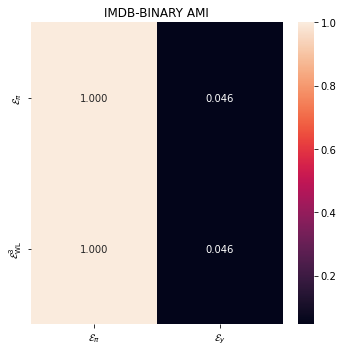

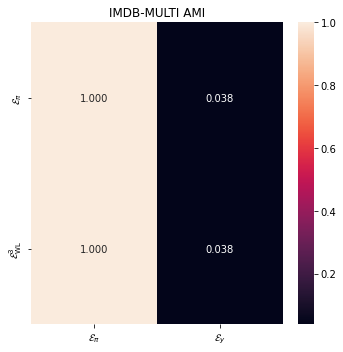

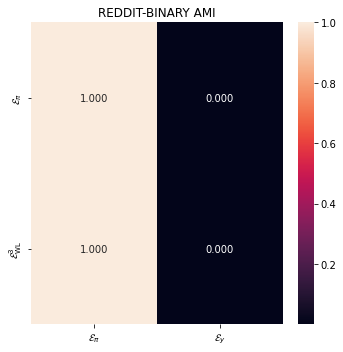

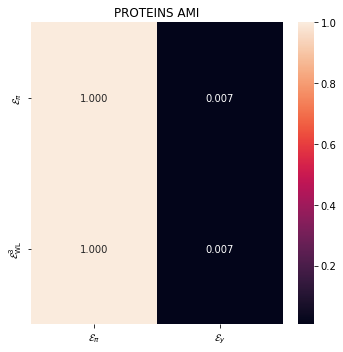

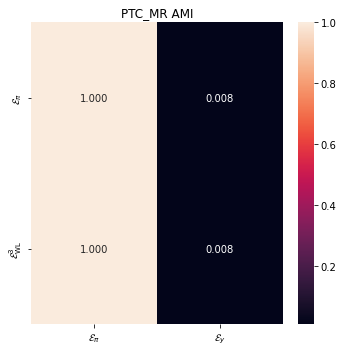

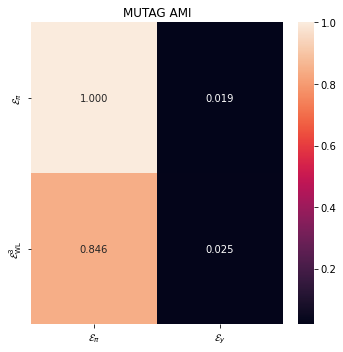

In [41]:
rc = {"font.family" : "sans-serif", 
      "mathtext.fontset" : "dejavusans"}
plt.rcParams.update(rc)

for dataset_name, dataset in all_datasets:
    print(dataset_name)
    
    if dataset_types[dataset_name][0] == "node":
        continue
        
    yticklabels = [r'${\cal E}_\pi$', r'${\cal E}_{\mathrm{WL}}^3$']
    xticklabels = [r'${\cal E}_\pi$', r'${\cal E}_y$']
        
    plt.figure(figsize=(5, 5))
    g = seaborn.heatmap(uncert_mat[dataset_name], annot=True, fmt=".3f", xticklabels=xticklabels, yticklabels=yticklabels)
    plt.title(dataset_name + " AMI")
    plt.tight_layout()
    
    results_dir = "./plots/AMI/"
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    plt.savefig(results_dir + dataset_name + "_AMI.pdf")

In [42]:
acc_stats = {}

for dataset_name, dataset in all_datasets:
    print(dataset_name)
        
    acc_stats[dataset_name] = acc_mat[dataset_name][:, 1].tolist()
        
cols = [r'${\cal E}_\pi \to {\cal E}_y$', r'${\cal E}_{\mathrm{WL}}^3 \to {\cal E}_y$']
pd_acc_stats = pd.DataFrame.from_dict(acc_stats, orient='index', columns=cols)
print(pd_acc_stats.round(2).to_latex(escape=False))

IMDB-BINARY
IMDB-MULTI
REDDIT-BINARY
PROTEINS
PTC_MR
MUTAG
Cora
CiteSeer
PubMed
\begin{tabular}{lrr}
\toprule
{} &  ${\cal E}_\pi \to {\cal E}_y$ &  ${\cal E}_{\mathrm{WL}}^3 \to {\cal E}_y$ \\
\midrule
IMDB-BINARY   &                      88.599998 &                                  88.599998 \\
IMDB-MULTI    &                      63.266666 &                                  63.266666 \\
REDDIT-BINARY &                     100.000000 &                                 100.000000 \\
PROTEINS      &                      99.730461 &                                  99.730461 \\
PTC_MR        &                      99.127907 &                                  99.127907 \\
MUTAG         &                     100.000000 &                                 100.000000 \\
Cora          &                     100.000000 &                                 100.000000 \\
CiteSeer      &                      99.969940 &                                  99.969940 \\
PubMed        &                     1